**Notebook Objective:**

Objective of the notebook is to explore the data and to build a simple baseline model.

**Objective of the competition:**

In this competition, you're challenged to build a model that recognizes toxicity and minimizes this type of unintended bias with respect to mentions of identities. You'll be using a dataset labeled for identity mentions and optimizing a metric designed to measure unintended bias. Develop strategies to reduce unintended bias in machine learning models, and you'll help the Conversation AI team, and the entire industry, build models that work well for a wide range of conversations.

In [3]:
import os
import json
import string
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD


pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

In [ ]:
import lightgbm as lgb

**Data Files:**

Following data files are given.

In [5]:
!ls ../data/raw/

jigsaw-unintended-bias-in-toxicity-classification.zip  test.csv
sample_submission.csv				       train.csv


* train.csv - the training set
* test.csv - the test set
* sample_submission.csv - A sample submission in the correct format

We are not allowed to use any external data sources. The following embeddings are given to us which can be used for building our models.

In [6]:
train_df = pd.read_csv("../data/raw/train.csv")
test_df = pd.read_csv("../data/raw/test.csv")
print("Train shape : ", train_df.shape)
print("Test shape : ", test_df.shape)

Train shape :  (1804874, 45)
Test shape :  (97320, 2)


In [7]:
train_df.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:41.987077+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:42.870083+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:45.222647+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:47.601894+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-09-29 10:50:48.488476+00,2,NaN,2006,rejected,0,0,0,1,0,0.0,4,47


**Target Distribution:**

First let us look at the distribution of the target variable to understand more about the imbalance and so on.

In [8]:
train_df['target'] = np.where(train_df['target'] >= 0.5, True, False)

In [9]:
## target count ##
cnt_srs = train_df['target'].value_counts()
trace = go.Bar(
    x=cnt_srs.index,
    y=cnt_srs.values,
    marker=dict(
        color=cnt_srs.values,
        colorscale = 'Picnic',
        reversescale = True
    ),
)

layout = go.Layout(
    title='Target Count',
    font=dict(size=18)
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="TargetCount")

## target distribution ##
labels = (np.array(cnt_srs.index))
sizes = (np.array((cnt_srs / cnt_srs.sum())*100))

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(
    title='Target distribution',
    font=dict(size=18),
    width=600,
    height=600,
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="usertype")

So about 8% of the training data are insincere questions (target=1) and rest of them are sincere. 

**Word Cloud:**

Now let us look at the frequently occuring words in the data by creating a word cloud on the 'question_text' column.

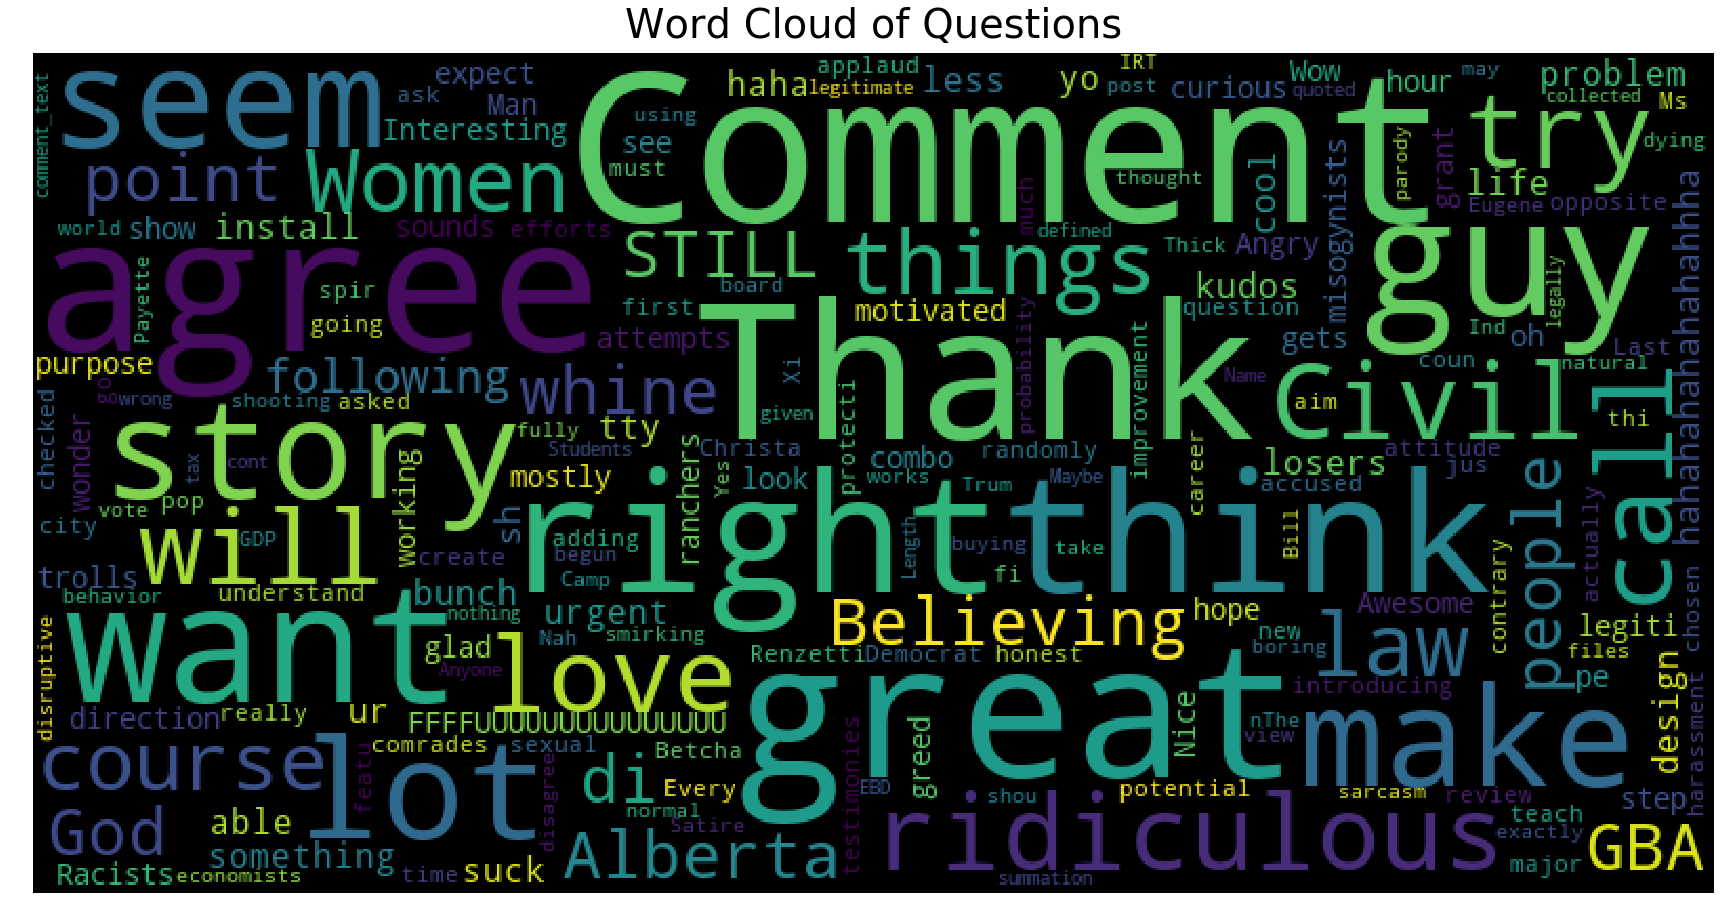

In [10]:
from wordcloud import WordCloud, STOPWORDS

# Thanks : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(train_df["comment_text"], title="Word Cloud of Questions")

There seem to be a variety of words in there. May be it is a good idea to look at the most frequent words in each of the classes separately.

**Word Frequency plot of sincere & insincere questions:****

In [12]:
from collections import defaultdict
train1_df = train_df[train_df["target"]==1]
train0_df = train_df[train_df["target"]==0]

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## Get the bar chart from sincere questions ##
freq_dict = defaultdict(int)
for sent in train0_df["comment_text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

## Get the bar chart from insincere questions ##
freq_dict = defaultdict(int)
for sent in train1_df["comment_text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of no toxic comments", 
                                          "Frequent words of toxic comments"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots')

#plt.figure(figsize=(10,16))
#sns.barplot(x="ngram_count", y="ngram", data=fd_sorted.loc[:50,:], color="b")
#plt.title("Frequent words for Insincere Questions", fontsize=16)
#plt.show()


This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



**Observations:**
* Some of the top words are common across both the classes like 'people', 'will', 'think' etc
* The other top words in sincere questions after excluding the common ones at the very top are 'best', 'good' etc
* The other top words in insincere questions after excluding the common ones are 'trump', 'women', 'white' etc

Now let us also create bigram frequency plots for both the classes separately to get more idea.

In [13]:
freq_dict = defaultdict(int)
for sent in train0_df["comment_text"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'orange')


freq_dict = defaultdict(int)
for sent in train1_df["comment_text"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'orange')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent bigrams of no toxic comments", 
                                          "Frequent bigrams of toxic comments"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Bigram Count Plots")
py.iplot(fig, filename='word-plots')


This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



**Observations:**
* The plot says it all. Please look at the plots and do the inference by yourselves ;)

Now let usl look at the trigram plots as well.

In [14]:
freq_dict = defaultdict(int)
for sent in train0_df["comment_text"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'green')


freq_dict = defaultdict(int)
for sent in train1_df["comment_text"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'green')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04, horizontal_spacing=0.2,
                          subplot_titles=["Frequent trigrams of no toxic comments", 
                                          "Frequent trigrams of toxic comments"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Trigram Count Plots")
py.iplot(fig, filename='word-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



**Meta Features:**

Now let us create some meta features and then look at how they are distributed between the classes. The ones that we will create are
1. Number of words in the text
2. Number of unique words in the text
3. Number of characters in the text
4. Number of stopwords
5. Number of punctuations
6. Number of upper case words
7. Number of title case words
8. Average length of the words

In [15]:
## Number of words in the text ##
train_df["num_words"] = train_df["comment_text"].apply(lambda x: len(str(x).split()))
test_df["num_words"] = test_df["comment_text"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text ##
train_df["num_unique_words"] = train_df["comment_text"].apply(lambda x: len(set(str(x).split())))
test_df["num_unique_words"] = test_df["comment_text"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the text ##
train_df["num_chars"] = train_df["comment_text"].apply(lambda x: len(str(x)))
test_df["num_chars"] = test_df["comment_text"].apply(lambda x: len(str(x)))

## Number of stopwords in the text ##
train_df["num_stopwords"] = train_df["comment_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
test_df["num_stopwords"] = test_df["comment_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

## Number of punctuations in the text ##
train_df["num_punctuations"] =train_df['comment_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test_df["num_punctuations"] =test_df['comment_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of title case words in the text ##
train_df["num_words_upper"] = train_df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test_df["num_words_upper"] = test_df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the text ##
train_df["num_words_title"] = train_df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test_df["num_words_title"] = test_df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the text ##
train_df["mean_word_len"] = train_df["comment_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df["mean_word_len"] = test_df["comment_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

Now let us see how these meta features are distributed between both sincere and insincere questions.

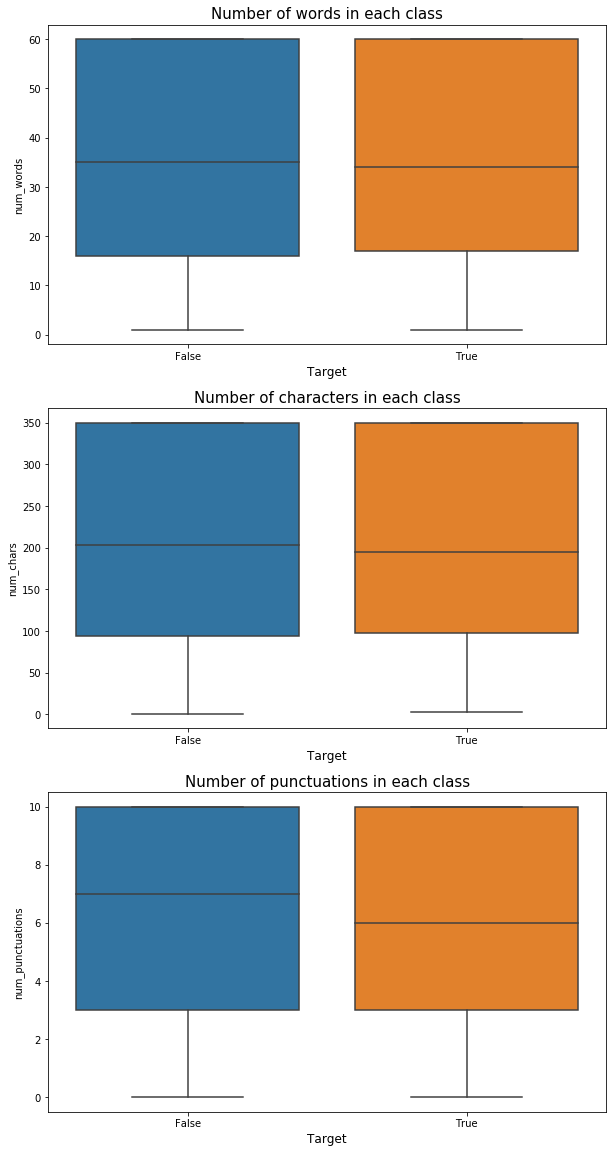

In [16]:
## Truncate some extreme values for better visuals ##
train_df['num_words'].loc[train_df['num_words']>60] = 60 #truncation for better visuals
train_df['num_punctuations'].loc[train_df['num_punctuations']>10] = 10 #truncation for better visuals
train_df['num_chars'].loc[train_df['num_chars']>350] = 350 #truncation for better visuals

f, axes = plt.subplots(3, 1, figsize=(10,20))
sns.boxplot(x='target', y='num_words', data=train_df, ax=axes[0])
axes[0].set_xlabel('Target', fontsize=12)
axes[0].set_title("Number of words in each class", fontsize=15)

sns.boxplot(x='target', y='num_chars', data=train_df, ax=axes[1])
axes[1].set_xlabel('Target', fontsize=12)
axes[1].set_title("Number of characters in each class", fontsize=15)

sns.boxplot(x='target', y='num_punctuations', data=train_df, ax=axes[2])
axes[2].set_xlabel('Target', fontsize=12)
#plt.ylabel('Number of punctuations in text', fontsize=12)
axes[2].set_title("Number of punctuations in each class", fontsize=15)
plt.show()


**Inference:**
* We can see that the insincere questions have more number of words as well as characters compared to sincere questions. So this might be a useful feature in our model.

**Baseline Model:**

To start with, let us just build a baseline model (Logistic Regression) with TFIDF vectors.

In [17]:
# Get the tfidf vectors #
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
tfidf_vec.fit_transform(train_df['comment_text'].values.tolist()) # + test_df['question_text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['comment_text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['comment_text'].values.tolist())

Let us build the model now.

In [18]:
train_y = train_df["target"].values

def runModel(train_X, train_y, test_X, test_y, test_X2):
    model = linear_model.LogisticRegression(C=5., solver='sag',n_jobs=-1)
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)[:,1]
    pred_test_y2 = model.predict_proba(test_X2)[:,1]
    return pred_test_y, pred_test_y2, model

print("Building model.")
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0]])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_df):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runModel(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break

Building model.


Getting the best threshold based on validation sample.

In [19]:
for thresh in np.arange(0.1, 0.201, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(val_y, (pred_val_y>thresh).astype(int))))


F1 score at threshold 0.1 is 0.61722687905539
F1 score at threshold 0.11 is 0.6247291636573741
F1 score at threshold 0.12 is 0.629903167569342
F1 score at threshold 0.13 is 0.6344603001489992
F1 score at threshold 0.14 is 0.6373768628441525
F1 score at threshold 0.15 is 0.6389738114880058
F1 score at threshold 0.16 is 0.6397629649247678
F1 score at threshold 0.17 is 0.6400689445402008
F1 score at threshold 0.18 is 0.6396267667464319
F1 score at threshold 0.19 is 0.6381727487529535
F1 score at threshold 0.2 is 0.6364915154644682


So we are getting a better F1 score for this model at 0.17.! 

Now let us look at the important words used for classifying the insincere questions. We will use eli5 library for the same. Thanks to [this excellent kernel](https://www.kaggle.com/lopuhin/eli5-for-mercari) by @lopuhin

In [20]:
import eli5
eli5.show_weights(model, vec=tfidf_vec, top=100, feature_filter=lambda x: x != '<BIAS>')

Weight?,Feature
+79.826,stupid
+65.382,idiot
+60.340,idiots
+55.159,stupidity
+45.537,pathetic
+44.026,idiotic
+43.730,crap
+42.265,ignorant
+39.095,fools
+38.885,dumb


**References:**

Thanks to all the below kernels which I used for reference.

1. https://www.kaggle.com/aashita/word-clouds-of-various-shapes
2. https://www.kaggle.com/tunguz/just-some-simple-eda
3. https://www.kaggle.com/lopuhin/eli5-for-mercari